In [33]:
### IMPORTS ###
import os
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import re
import datetime

## Data Wrangling

In [34]:
### SET WORKING DIRECTORY ###
path = "/Users/JKM/Desktop/Python/apple_health_export"
os.chdir(path)
os.getcwd()

'/Users/jkm/Desktop/Python/apple_health_export'

In [35]:
# Create dataframe
tree = et.parse('export.xml')
root = tree.getroot()
df_cols = ['types', 'sourceName', 'sourceVersion', 'device', 'name', 'manufacturer', 'model',
          'hardware', 'software', 'unit', 'creationDate', 'startDate', 'endDate', 'value']
rows = []

for node in root:
    if node.attrib.get('type') in ['HKQuantityTypeIdentifierStepCount']:
        types = node.attrib.get('type') if node is not None else None
        sourceName = node.attrib.get('sourceName') if node is not None else None
        sourceVersion = node.attrib.get('sourceVersion') if node is not None else None
        device = node.attrib.get('device') if node is not None else None
        name = node.attrib.get('name') if node is not None else None
        manufacturer = node.attrib.get('manufacturer') if node is not None else None
        model = node.attrib.get('iPhone') if node is not None else None
        hardware = node.attrib.get('hardware') if node is not None else None
        software = node.attrib.get('software') if node is not None else None
        unit = node.attrib.get('unit') if node is not None else None
        creationDate = node.attrib.get('creationDate') if node is not None else None
        startDate = node.attrib.get('startDate') if node is not None else None
        endDate = node.attrib.get('endDate') if node is not None else None
        value = node.attrib.get('value') if node is not None else None
        
        rows.append({'types':types,'sourceName':sourceName,'sourceVersion':sourceVersion,
                     'device':device,'name':name,'manufacturer':manufacturer,
                     'model':model,'hardware':hardware,'software': software, 'unit': unit,
                     'creationDate': creationDate,'startDate':startDate,'endDate':endDate,
                     'value':value})

df = pd.DataFrame(rows, columns=df_cols)
df.head(2)

,types,sourceName,sourceVersion,device,name,manufacturer,model,hardware,software,unit,creationDate,startDate,endDate,value
0,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,"<<HKDevice: 0x281e244b0>, name:iPhone, manufac...",None,None,None,None,None,count,2017-02-04 18:40:43 -0500,2017-02-04 17:46:36 -0500,2017-02-04 17:53:30 -0500,13
1,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,"<<HKDevice: 0x281e24c80>, name:iPhone, manufac...",None,None,None,None,None,count,2017-02-04 18:40:43 -0500,2017-02-04 17:53:30 -0500,2017-02-04 17:58:52 -0500,8


In [36]:
# Fix device-related columns
cols_update = ['device', 'name', 'manufacturer', 'model', 'hardware', 'software']
rows_update = []
for i in range(len(df.iloc[:,3])):
    if df.iloc[:,1][i] == 'Health':
        rows_update.append({'device':None, 'name':None, 'manufacturer':None,
                                  'model':None, 'hardware':None, 'software':None}) 
    else:
        text = df.iloc[:,3][i]
        text = text.replace('<', '')
        text = text.replace('>', '')
        device_list = re.split(', |:', text)
        rows_update.append({'device':device_list[1],'name':device_list[3], 
                            'manufacturer':device_list[5],'model':device_list[7], 
                            'hardware':device_list[9], 'software':device_list[11]})

update_df = pd.DataFrame(rows_update, columns=cols_update)
for i in cols_update:
    df[i] = update_df[i]
df.head(2)

,types,sourceName,sourceVersion,device,name,manufacturer,model,hardware,software,unit,creationDate,startDate,endDate,value
0,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,0x281e244b0,iPhone,Apple,iPhone,"iPhone8,4",10.2.1,count,2017-02-04 18:40:43 -0500,2017-02-04 17:46:36 -0500,2017-02-04 17:53:30 -0500,13
1,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,0x281e24c80,iPhone,Apple,iPhone,"iPhone8,4",10.2.1,count,2017-02-04 18:40:43 -0500,2017-02-04 17:53:30 -0500,2017-02-04 17:58:52 -0500,8


In [37]:
# Add date/time columns
df['yearSD'] = df.apply(lambda x: x['startDate'][0:4], axis=1)
df['monthSD'] = df.apply(lambda x: x['startDate'][5:7], axis=1)
df['daySD'] = df.apply(lambda x: x['startDate'][8:10], axis=1)
df['hourSD'] = df.apply(lambda x: x['startDate'][11:13], axis=1)
df['timezoneSD'] = df.apply(lambda x: x['startDate'][-5:], axis=1)
df.head(2)

,types,sourceName,sourceVersion,device,name,manufacturer,model,hardware,software,unit,creationDate,startDate,endDate,value,yearSD,monthSD,daySD,hourSD,timezoneSD
0,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,0x281e244b0,iPhone,Apple,iPhone,"iPhone8,4",10.2.1,count,2017-02-04 18:40:43 -0500,2017-02-04 17:46:36 -0500,2017-02-04 17:53:30 -0500,13,2017,02,04,17,-0500
1,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,0x281e24c80,iPhone,Apple,iPhone,"iPhone8,4",10.2.1,count,2017-02-04 18:40:43 -0500,2017-02-04 17:53:30 -0500,2017-02-04 17:58:52 -0500,8,2017,02,04,17,-0500


In [38]:
# Adjust data types
df.yearSD = pd.to_numeric(df.yearSD, errors='coerce')
df.monthSD = pd.to_numeric(df.monthSD, errors='coerce')
df.daySD = pd.to_numeric(df.daySD, errors='coerce')
df.hourSD = pd.to_numeric(df.hourSD, errors='coerce')
df.value = pd.to_numeric(df.value, errors='coerce')

In [39]:
# Add weekDay column
df['weekDay'] = df.apply(lambda x: datetime.date(x['yearSD'], 
                                                 x['monthSD'], 
                                                 x['daySD']).strftime("%a"), axis=1)
df.head(2)

,types,sourceName,sourceVersion,device,name,manufacturer,model,hardware,software,unit,creationDate,startDate,endDate,value,yearSD,monthSD,daySD,hourSD,timezoneSD,weekDay
0,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,0x281e244b0,iPhone,Apple,iPhone,"iPhone8,4",10.2.1,count,2017-02-04 18:40:43 -0500,2017-02-04 17:46:36 -0500,2017-02-04 17:53:30 -0500,13,2017,2,4,17,-0500,Sat
1,HKQuantityTypeIdentifierStepCount,JKM II,10.2.1,0x281e24c80,iPhone,Apple,iPhone,"iPhone8,4",10.2.1,count,2017-02-04 18:40:43 -0500,2017-02-04 17:53:30 -0500,2017-02-04 17:58:52 -0500,8,2017,2,4,17,-0500,Sat


In [40]:
# Remove Japan/China trips (2017: May 1-21, 2019: April 9-16)*
# * these steps are (1) much higher than normal and 
#   (2) are recorded in UTC+5 despite happening in and around UTC-9
df = df.drop(df[(df.yearSD == 2017) & 
                (df.monthSD == 5) & 
                (df.daySD.isin(list(range(1,22))))].index)
df = df.drop(df[(df.yearSD == 2019) & 
                (df.monthSD == 4) & 
                (df.daySD.isin(list(range(9,17))))].index)

## Data Exploration

In [41]:
# Unique values
print(df.sourceName.unique())
print(df.sourceVersion.unique())
print(df.name.unique())
print(df.model.unique())
print(df.hardware.unique())
print(df.timezoneSD.unique())

['JKM II' 'Health' 'JKM 3']
['10.2.1' '10.3.1' '10.3.2' '10.3.3' '11.0.1' '11.0.2' '11.0.3' '11.0'
 '11.1.2' '11.2.5' '11.2.6' '11.4' '11.4.1' '12.0.1' '12.1.1' '12.1.2'
 '12.1.4' '12.2' '12.3.1' '12.4' '12.4.1']
['iPhone' None]
['iPhone' None]
['iPhone8,4' None 'iPhone10,3']
['-0500']


In [42]:
# 'Health' sourceName
df.loc[df['sourceName'] == 'Health']

,types,sourceName,sourceVersion,device,name,manufacturer,model,hardware,software,unit,creationDate,startDate,endDate,value,yearSD,monthSD,daySD,hourSD,timezoneSD,weekDay
24686,HKQuantityTypeIdentifierStepCount,Health,11.4.1,None,None,None,None,None,None,count,2018-08-18 18:26:15 -0500,2018-08-18 18:26:00 -0500,2018-08-18 18:26:00 -0500,8000,2018,8,18,18,-0500,Sat


In [43]:
# Group step count by hour of day
hours_df = df[['yearSD', 'hourSD', 'value']]
hours_df = pd.pivot_table(hours_df, values='value', index=['hourSD'], 
                          columns=['yearSD'], aggfunc=np.sum)
hours_df.drop(columns=[2014, 2015], inplace=True)
print(hours_df.head(5))

yearSD     2017     2018     2019
hourSD                           
0       56995.0  18037.0   6823.0
1       11569.0  14761.0   1879.0
2        2710.0   1198.0    726.0
3        1186.0   1715.0    634.0
4         554.0   1034.0  13510.0


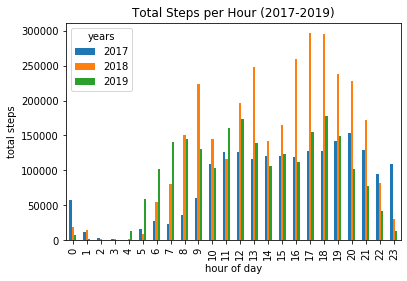

In [44]:
# Hour of day graph
p = hours_df.plot.bar(title='Total Steps per Hour (2017-2019)')
p.set_xlabel('hour of day')
p.set_ylabel('total steps')
p.legend(title='years')

In [45]:
# Create weekday/weekend tables
new_df = df[['weekDay', 'yearSD', 'hourSD', 'value']]
weekday_df = new_df.loc[~new_df['weekDay'].isin(['Sat', 'Sun'])]
weekend_df = new_df.loc[new_df['weekDay'].isin(['Sat', 'Sun'])]

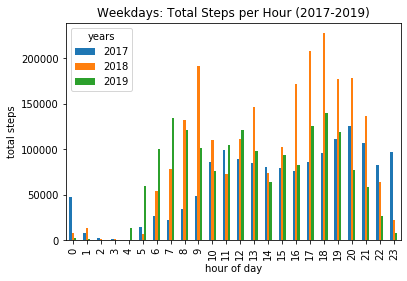

In [47]:
# Weekday graph
weekday_df = pd.pivot_table(weekday_df, values='value', index=['hourSD'], 
                            columns=['yearSD'], aggfunc=np.sum)
weekday_df.drop(columns=[2014, 2015], inplace=True)
q = weekday_df.plot.bar(title='Weekdays: Total Steps per Hour (2017-2019)')
q.set_xlabel('hour of day')
q.set_ylabel('total steps')
q.legend(title='years')

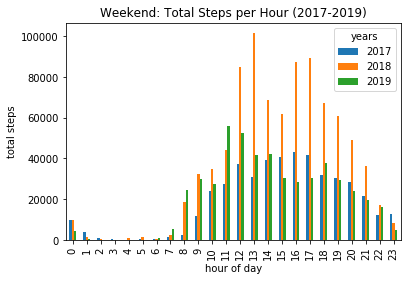

In [48]:
# Weekend graph
weekend_df = pd.pivot_table(weekend_df, values='value', index=['hourSD'], 
                            columns=['yearSD'], aggfunc=np.sum)
q = weekend_df.plot.bar(title='Weekend: Total Steps per Hour (2017-2019)')
q.set_xlabel('hour of day')
q.set_ylabel('total steps')
q.legend(title='years')